In [1]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"


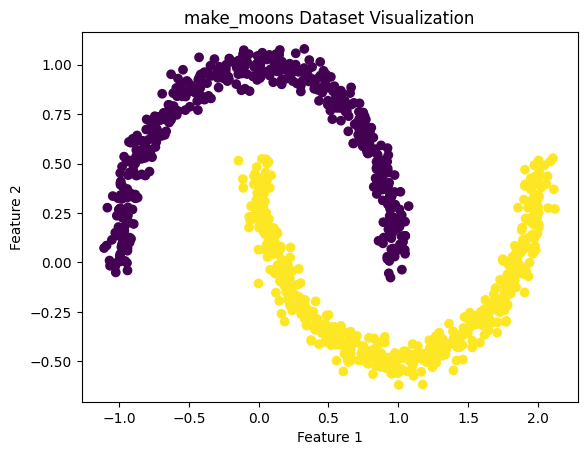

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate make_moons dataset
# n_samples: The total number of points generated.
# noise: Standard deviation of Gaussian noise added to the data.
# random_state: Determines random number generation for dataset creation.
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

# Create a scatter plot
# X[:, 0]: All rows, first column (x-coordinates)
# X[:, 1]: All rows, second column (y-coordinates)
# c=y: Color points based on their class label (0 or 1)
# cmap='viridis': Colormap to use for coloring the points
# marker='o': Marker style for the points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', marker='o')

# Add title and labels for clarity
plt.title('make_moons Dataset Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Display the plot
plt.show()


In [4]:
class Flow(nn.Module):
    def __init__(self,dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(), 
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim)
        )
    def forward(self,x: Tensor, t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x), -1))

    def step(self, X_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1) # (1,1)
        t_start = t_start.expand(X_t.shape[0], 1) # B,1

        out = X_t + (t_end - t_start) * self(X_t, t_start)
        return out

    def step_midpoint(self, X_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1) # (1,1)
        t_start = t_start.expand(X_t.shape[0], 1) # B,1
        
        out = X_t + (t_end - t_start) * self(X_t + self(X_t, t_start) * (t_end - t_start) / 2, t_start + (t_end - t_start) / 2)
        return out

flow = Flow().to(device)

In [ ]:
optimizer = torch.optim.AdamW(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

In [ ]:
steps = 10000
B = 1024

for i in tqdm(range(steps)):
    #random noise input
    X_0 = torch.randn((B,2)).to(device)
    #target
    X_1 = Tensor(make_moons(n_samples=B, noise=0.05, random_state=42)[0]).to(device)

    #Time step
    T = torch.rand((B, 1)).to(device)
    #calculate flow from X_0 -> X_1 at timestep T
    X_t = ((1 - T) * X_0) + (T * X_1)
    #FORWARD
    out = flow(X_t, T)

    dX_t = X_1 - X_0

    optimizer.zero_grad()
    loss_fn(out, dX_t).backward()
    optimizer.step()


100%|██████████| 10000/10000 [00:08<00:00, 1230.44it/s]


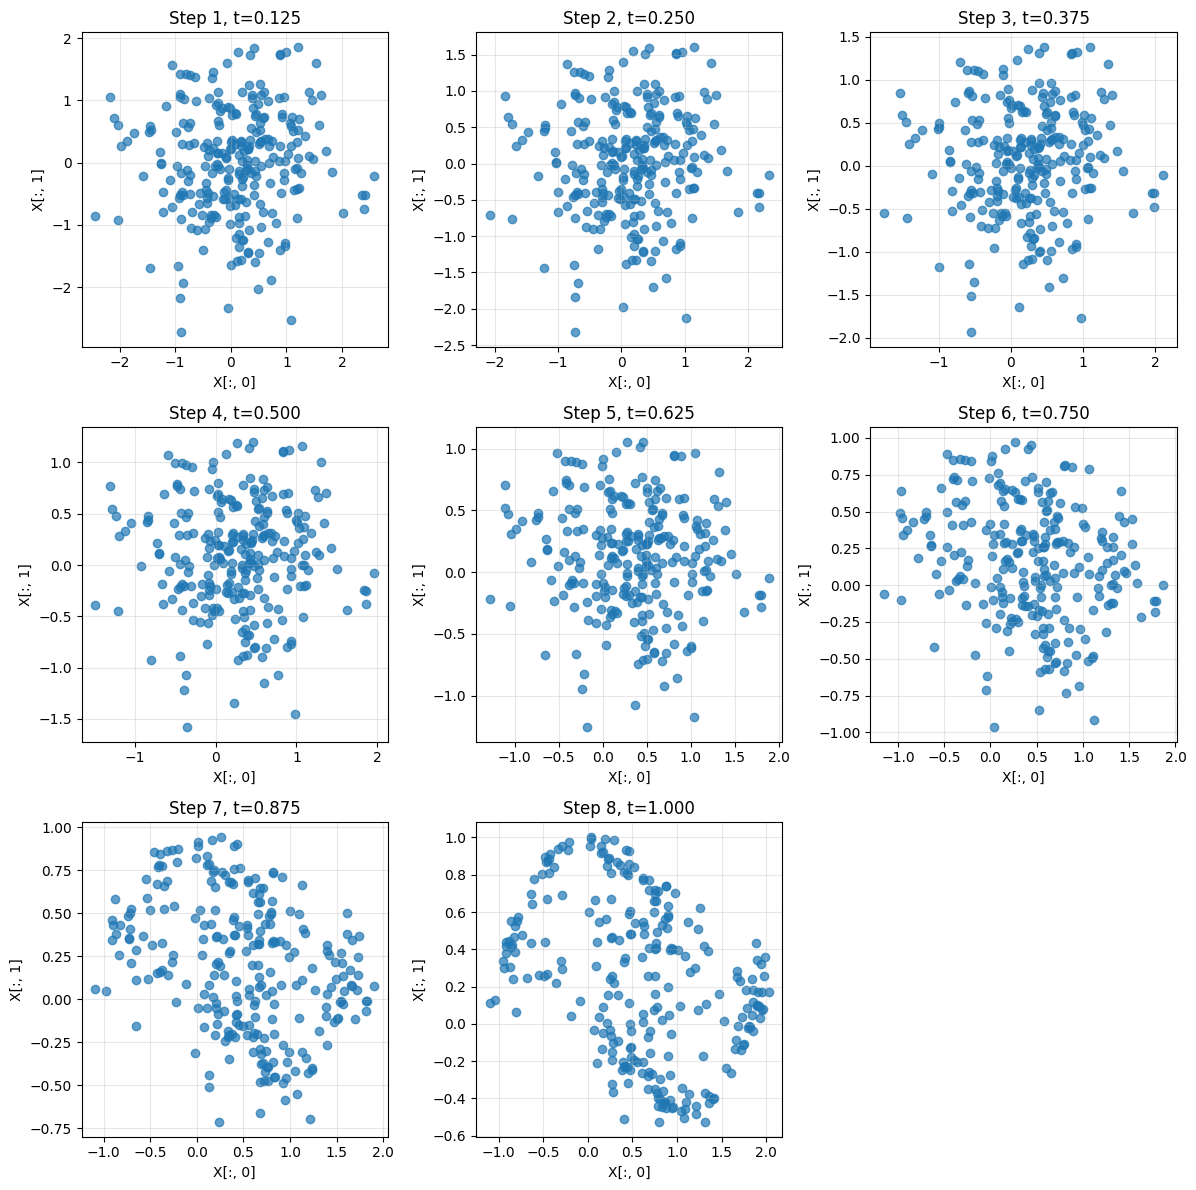

In [13]:
import math

n_steps = 8
time_steps = torch.linspace(0, 1.0, n_steps + 1).to(device)

# Calculate grid dimensions
n_cols = math.ceil(math.sqrt(n_steps))
n_rows = math.ceil(n_steps / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten() if n_steps > 1 else [axes]

with torch.no_grad():
   X_t = torch.randn((B,2)).to(device)
   for i in range(n_steps):
       out = flow.step(X_t, time_steps[i], time_steps[i + 1])

       out_cpu = out.to("cpu")
       axes[i].scatter(out_cpu[:, 0], out_cpu[:, 1], alpha=0.7)
       axes[i].set_title(f'Step {i+1}, t={time_steps[i+1]:.3f}')
       axes[i].set_xlabel('X[:, 0]')
       axes[i].set_ylabel('X[:, 1]')
       axes[i].grid(True, alpha=0.3)
       
       X_t = out  # Update for next step

# Hide unused subplots
for i in range(n_steps, len(axes)):
   axes[i].set_visible(False)

plt.tight_layout()
plt.show()

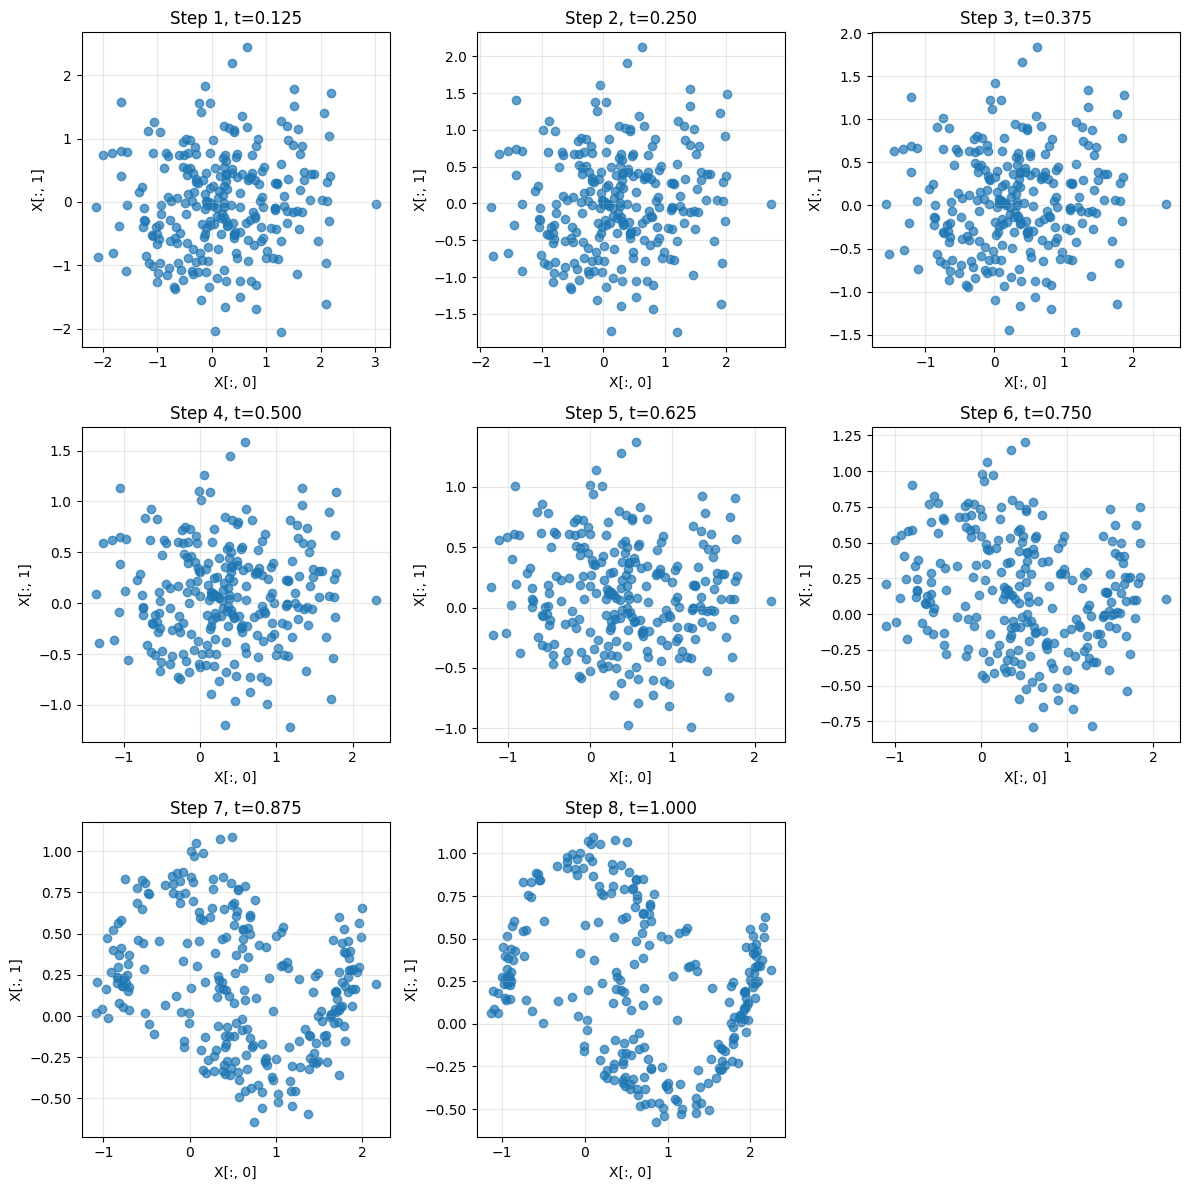

In [14]:
import math

n_steps = 8
time_steps = torch.linspace(0, 1.0, n_steps + 1).to(device)

# Calculate grid dimensions
n_cols = math.ceil(math.sqrt(n_steps))
n_rows = math.ceil(n_steps / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten() if n_steps > 1 else [axes]

with torch.no_grad():
   X_t = torch.randn((B,2)).to(device)
   for i in range(n_steps):
       out = flow.step_midpoint(X_t, time_steps[i], time_steps[i + 1])

       out_cpu = out.to("cpu")
       axes[i].scatter(out_cpu[:, 0], out_cpu[:, 1], alpha=0.7)
       axes[i].set_title(f'Step {i+1}, t={time_steps[i+1]:.3f}')
       axes[i].set_xlabel('X[:, 0]')
       axes[i].set_ylabel('X[:, 1]')
       axes[i].grid(True, alpha=0.3)
       
       X_t = out  # Update for next step

# Hide unused subplots
for i in range(n_steps, len(axes)):
   axes[i].set_visible(False)

plt.tight_layout()
plt.show()